# Lesson 14.3 Batch Normalization综合调参实战

&emsp;&emsp;根据Lesson 14.2最后一部分实验结果不难看出，带BN层的模型并不一定比不带BN层模型效果好，要充分发挥BN层的效果，就必须掌握一些围绕带BN层模型的调参理论和调参技巧。

## 一、Batch Normalization与Batch_size综合调参

&emsp;&emsp;我们知道，BN是一种在长期实践中被证明行之有效的优化方法，但在使用过程中首先需要知道，BN的理论基础（尽管不完全正确）是以BN层能够有效预估输入数据整体均值和方差为前提的，如果不能尽可能的从每次输入的小批数据中更准确的估计整体统计量，则后续的平移和放缩也将是有偏的。而由小批数据估计整体统计量的可信度其实是和小批数据本身数量相关的，如果小批数据数量太少，则进行整体统计量估计时就将有较大偏差，此时会影响模型准确率。

&emsp;&emsp;因此，一般来说，我们在使用BN时，至少需要保证小批数据量（batch_size)在15-30以上，才能进行相对准确的预估。此处我们适当调整小批数据量参数，再进行模型计算。

In [2]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# 自定义模块
from torchLearning import *

# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels, batch_size=50)

In [4]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
sigmoid_model1 = net_class1(act_fun= torch.sigmoid)    
sigmoid_model1_norm = net_class1(act_fun= torch.sigmoid,BN_model='pre')                                            
        
# 创建模型容器
model_l = [sigmoid_model1, sigmoid_model1_norm]           
name_l = ['sigmoid_model1', 'sigmoid_model1_norm']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

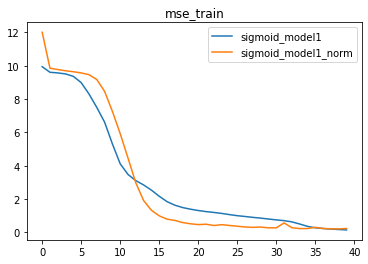

In [5]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

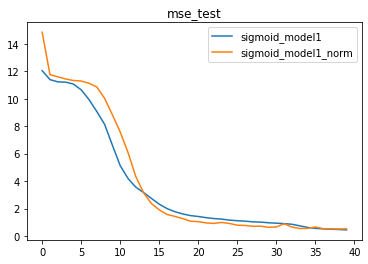

In [6]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

In [ ]:
train_l[:, -1]

tensor([0.1531, 0.3152])

我们发现，当提升batch_size之后，带BN层的模型效果有明显提升，相比原始模型，带BN层的模型拥有更快的收敛速度。

&emsp;&emsp;当然，为了确保BN层对整体统计量估计的可信度，除了提高batch_size之外，还能够通过调低momentum参数来实现，当然，伴随着momentum值得降低，我们也必须进一步提升遍历数据集得次数，同学们可以根据上述代码自行进行实验。

## 二、复杂模型上的Batch_normalization表现

&emsp;&emsp;一般来说，BN方法对于复杂模型和复杂数据会更加有效，换而言之，很多简单模型是没必要使用BN层（徒增计算量）。对于上述net_class1来说，由于只存在一个隐藏层，因此也不会存在梯度不平稳的现象，而BN层的优化效果也并不明显。接下来，我们尝试构建更加复杂的模型，来测试BN层的优化效果。

> 从另一个角度来说，其实我们是建议更频繁的使用更加复杂的模型并带上BN层的，核心原因在于，复杂模型带上BN层之后会有更大的优化空间。

接下来，我们尝试设置更加复杂的数据集，同时增加模型复杂度，测试在更加复杂的环境下BN层表现情况。

此处我们创建满足$y=2x_1^2-x_2^2+3x_3^2+x_4^2+2x_5^2$的回归类数据集。

In [7]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1, 3, 1, 2], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels, batch_size=50)

接下来，我们同时创建Sigmoid1-4，并且通过对比带BN层的模型和不带BN层的模型来进行测试。

In [8]:
# class1对比模型
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
sigmoid_model1 = net_class1(act_fun= torch.sigmoid, in_features=5)
sigmoid_model1_norm = net_class1(act_fun= torch.sigmoid, in_features=5, BN_model='pre')

# 创建模型容器
model_ls1 = [sigmoid_model1, sigmoid_model1_norm]           
name_ls1 = ['sigmoid_model1', 'sigmoid_model1_norm']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_ls1, test_ls1 = model_comparison(model_l = model_ls1, 
                                       name_l = name_ls1, 
                                       train_data = train_loader,
                                       test_data = test_loader,
                                       num_epochs = num_epochs, 
                                       criterion = nn.MSELoss(), 
                                       optimizer = optim.SGD, 
                                       lr = lr, 
                                       cla = False, 
                                       eva = mse_cal)


# class2对比模型
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
sigmoid_model2 = net_class2(act_fun= torch.sigmoid, in_features=5)
sigmoid_model2_norm = net_class2(act_fun= torch.sigmoid, in_features=5, BN_model='pre')

# 创建模型容器
model_ls2 = [sigmoid_model2, sigmoid_model2_norm]           
name_ls2 = ['sigmoid_model2', 'sigmoid_model2_norm']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_ls2, test_ls2 = model_comparison(model_l = model_ls2, 
                                       name_l = name_ls2, 
                                       train_data = train_loader,
                                       test_data = test_loader,
                                       num_epochs = num_epochs, 
                                       criterion = nn.MSELoss(), 
                                       optimizer = optim.SGD, 
                                       lr = lr, 
                                       cla = False, 
                                       eva = mse_cal)

# class3对比模型
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
sigmoid_model3 = net_class3(act_fun= torch.sigmoid, in_features=5)
sigmoid_model3_norm = net_class3(act_fun= torch.sigmoid, in_features=5, BN_model='pre')

# 创建模型容器
model_ls3 = [sigmoid_model3, sigmoid_model3_norm]           
name_ls3 = ['sigmoid_model3', 'sigmoid_model3_norm']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_ls3, test_ls3 = model_comparison(model_l = model_ls3, 
                                       name_l = name_ls3, 
                                       train_data = train_loader,
                                       test_data = test_loader,
                                       num_epochs = num_epochs, 
                                       criterion = nn.MSELoss(), 
                                       optimizer = optim.SGD, 
                                       lr = lr, 
                                       cla = False, 
                                       eva = mse_cal)

# class4对比模型
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
sigmoid_model4 = net_class4(act_fun= torch.sigmoid, in_features=5)
sigmoid_model4_norm = net_class4(act_fun= torch.sigmoid, in_features=5, BN_model='pre')

# 创建模型容器
model_ls4 = [sigmoid_model4, sigmoid_model4_norm]           
name_ls4 = ['sigmoid_model4', 'sigmoid_model4_norm']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_ls4, test_ls4 = model_comparison(model_l = model_ls4, 
                                       name_l = name_ls4, 
                                       train_data = train_loader,
                                       test_data = test_loader,
                                       num_epochs = num_epochs, 
                                       criterion = nn.MSELoss(), 
                                       optimizer = optim.SGD, 
                                       lr = lr, 
                                       cla = False, 
                                       eva = mse_cal)

Text(0.5, 1.0, 'mse_train_ls1')

Text(0.5, 1.0, 'mse_train_ls2')

Text(0.5, 1.0, 'mse_train_ls3')

Text(0.5, 1.0, 'mse_train_ls4')

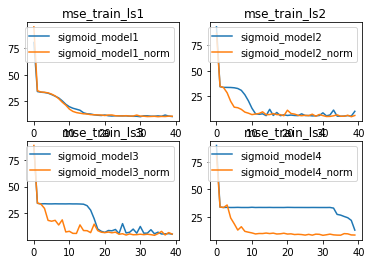

In [9]:
# 训练误差
plt.subplot(221)
for i, name in enumerate(name_ls1):
    plt.plot(list(range(num_epochs)), train_ls1[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train_ls1')

plt.subplot(222)
for i, name in enumerate(name_ls2):
    plt.plot(list(range(num_epochs)), train_ls2[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train_ls2')

plt.subplot(223)
for i, name in enumerate(name_ls3):
    plt.plot(list(range(num_epochs)), train_ls3[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train_ls3')

plt.subplot(224)
for i, name in enumerate(name_ls4):
    plt.plot(list(range(num_epochs)), train_ls4[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train_ls4')

Text(0.5, 1.0, 'mse_test_ls1')

Text(0.5, 1.0, 'mse_test_ls2')

Text(0.5, 1.0, 'mse_test_ls3')

Text(0.5, 1.0, 'mse_test_ls4')

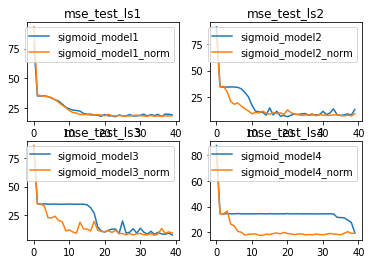

In [10]:
# 训练误差
plt.subplot(221)
for i, name in enumerate(name_ls1):
    plt.plot(list(range(num_epochs)), test_ls1[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test_ls1')

plt.subplot(222)
for i, name in enumerate(name_ls2):
    plt.plot(list(range(num_epochs)), test_ls2[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test_ls2')

plt.subplot(223)
for i, name in enumerate(name_ls3):
    plt.plot(list(range(num_epochs)), test_ls3[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test_ls3')

plt.subplot(224)
for i, name in enumerate(name_ls4):
    plt.plot(list(range(num_epochs)), test_ls4[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test_ls4')

&emsp;&emsp;由此，我们可以清楚的看到，BN层对更加复杂模型的优化效果更好。换而言之，越复杂的模型对于梯度不平稳的问题就越明显，因此BN层在解决该问题后模型效果提升就越明显。

&emsp;&emsp;并且，针对复杂数据集，在一定范围内，伴随模型复杂度提升，模型效果会有显著提升。

Text(0.5, 1.0, 'mse_test')

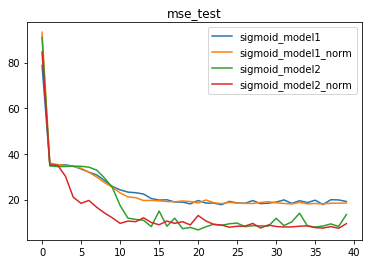

In [11]:
for i, name in enumerate(name_ls1):
    plt.plot(list(range(num_epochs)), test_ls1[i], label=name)
for i, name in enumerate(name_ls2):
    plt.plot(list(range(num_epochs)), test_ls2[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

> 这也算是对Lesson 13.2节实验的一个补充。

不过呢，和Lesson 13.2中我们看到的一样，模型复杂度提升也是过犹不及的，当模型太过于复杂时，仍然会出现模型效果下降的问题。

Text(0.5, 1.0, 'mse_test')

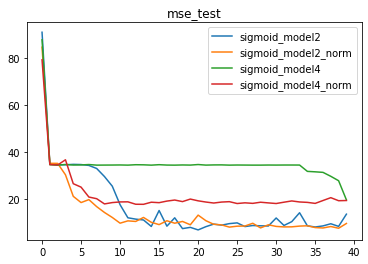

In [12]:
for i, name in enumerate(name_ls2):
    plt.plot(list(range(num_epochs)), test_ls2[i], label=name)
for i, name in enumerate(name_ls4):
    plt.plot(list(range(num_epochs)), test_ls4[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

> 关于该问题的解决，我们会在下一节课详细讨论。

&emsp;&emsp;对于Sigmoid来说，BN层能很大程度上缓解梯度消失问题，从而提升模型收敛速度，并且小幅提升模型效果。而对于激活函数本身就能输出Zero-Centered结果的tanh函数，BN层的优化效果会更好。

In [13]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model2 = net_class2(act_fun= torch.tanh, in_features=5)
tanh_model2_norm = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')
     
# 创建模型容器
model_l = [tanh_model2, tanh_model2_norm]           
name_l = ['tanh_model2', 'tanh_model2_norm']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_lh, test_lh = model_comparison(model_l = model_l, 
                                     name_l = name_l, 
                                     train_data = train_loader,
                                     test_data = test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = lr, 
                                     cla = False, 
                                     eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

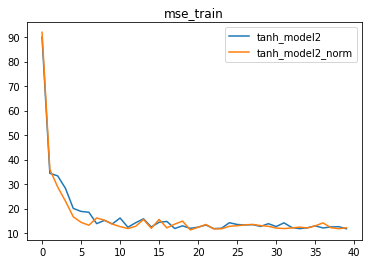

In [14]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_lh[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

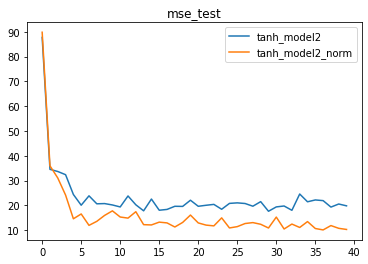

In [ ]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_lh[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

&emsp;&emsp;相比Sigmoid，使用tanh激活函数本身就是更加复杂的一种选择，因此，BN层在tanh上所表现出的更好的优化效果，也能看成是BN在复杂模型上效果有所提升。此处对上述模型最终输出结果进行记录，方便后续进行对比实验。

In [ ]:
# 查看训练过程记录的训练误差
train_lh

tensor([[90.0410, 34.2639, 33.5446, 31.9212, 22.0810, 14.7903, 18.2581, 15.1839,
         15.0624, 13.4452, 13.3091, 17.7788, 12.6565, 11.9330, 16.1119, 12.4954,
         11.9774, 12.8171, 12.2254, 16.0338, 11.6438, 11.7511, 13.2774, 12.3326,
         16.8244, 13.2940, 12.2150, 13.4788, 12.8132, 12.2014, 11.8137, 12.7440,
         14.1324, 14.7191, 12.5409, 13.5861, 14.6481, 11.7442, 12.4439, 11.3137],
        [92.0081, 35.4041, 31.0103, 20.1494, 13.1830, 13.0195,  9.2834, 10.0762,
         13.4778, 14.2828, 13.9647, 10.2997, 12.4788,  8.2775,  8.8962,  8.8409,
          9.2877,  8.0714,  9.1343, 11.6036,  8.8645,  8.7513,  7.7945, 12.4266,
          7.2719,  7.2385,  8.5118,  9.3777,  8.7197,  7.2678, 11.7509,  6.8817,
          9.5968,  7.1690,  9.8368,  6.9078,  6.7576,  9.6106,  7.4212,  7.3070]])

In [ ]:
# 查看最后五次训练误差计算结果
train_lh[1:,-5:]

tensor([[6.9078, 6.7576, 9.6106, 7.4212, 7.3070]])

In [ ]:
train_lh[1:,-5:].mean()

tensor(7.6008)

In [ ]:
test_lh[1:,-5:].mean()

tensor(10.7237)

## 三、包含BN层的神经网络的学习率优化

&emsp;&emsp;根据此前的实验结果，我们不难发现，BN层对模型迭代的平稳性提升帮助不大，相反，加入BN层的模型收敛过程“不平稳”的特点好像有增无减，这点从Sigmoid激活函数的收敛过程看的尤其明显。

&emsp;&emsp;而收敛不平稳的模型，一般都对学习率非常敏感（相关内容我们会在后续学习率优化章节详细讨论），也就是学习率的调整将有效缓解迭代不平稳的问题，而一旦迭代不平稳被修正，模型就有可能最后收敛到一个更优的结果，当然，这只是有可能，最终结果还需要看到底是什么原因导致模型收敛过程不平稳。而BN层所带来的不平稳性，我们可以简单理解成模型可以在更大范围搜索最优解，相比不带BN层的神经网络模型，带BN层的神经网络的不平稳会更大程度受到学习率的影响。换而言之，带BN层的神经网络模型对学习率是高度敏感的，并且带BN层的神经网络模型，在进行学习率调整时能够有更大的优化空间。也就是说，相比不带BN层的模型，带BN层的模型在同样进行某种学习率调整时，会有更好的效果。

> 一般有很多材料简单认为添加BN层的神经网络模型可以通过提高学习率来加快收敛速度，但对于学习率敏感的BN层来说，一味增加学习率可能并不是最优方法。

&emsp;&emsp;为了更好的说明所谓优化空间，我们需要铺垫两个基础认知，其一是学习率敏感度，其二是学习率学习曲线（伴随学习率调整模型效果变化曲线）。

### 1.学习率敏感度

&emsp;&emsp;首先，我们通过简单实验来观测带BN层的模型对于学习率的敏感程度。我们挑选相对复杂、迭代不平稳的tanh3和tanh4模型进行实验。

In [ ]:
# 0.1学习率
# 创建随机数种子
torch.manual_seed(24)  

# 实例化模型   
tanh_model3 = net_class3(act_fun=torch.tanh, in_features=5)                          
tanh_model3_norm = net_class3(act_fun=torch.tanh, in_features=5, BN_model='pre') 
tanh_model4 = net_class4(act_fun=torch.tanh, in_features=5)                          
tanh_model4_norm = net_class4(act_fun=torch.tanh, in_features=5, BN_model='pre')    
        
# 创建模型容器
model_l = [tanh_model3, tanh_model3_norm, tanh_model4, tanh_model4_norm]           
name_l = ['tanh_model3', 'tanh_model3_norm', 'tanh_model4', 'tanh_model4_norm']

# 核心参数
num_epochs = 40
lr = 0.1

# 模型训练
train_l1, test_l1 = model_comparison(model_l = model_l, 
                                     name_l = name_l, 
                                     train_data = train_loader,
                                     test_data = test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = lr, 
                                     cla = False, 
                                     eva = mse_cal)


# 0.03学习率
# 创建随机数种子
torch.manual_seed(24)  

# 实例化模型   
tanh_model3 = net_class3(act_fun=torch.tanh, in_features=5)                          
tanh_model3_norm = net_class3(act_fun=torch.tanh, in_features=5, BN_model='pre') 
tanh_model4 = net_class4(act_fun=torch.tanh, in_features=5)                          
tanh_model4_norm = net_class4(act_fun=torch.tanh, in_features=5, BN_model='pre')    
        
# 创建模型容器
model_l = [tanh_model3, tanh_model3_norm, tanh_model4, tanh_model4_norm]           
name_l = ['tanh_model3', 'tanh_model3_norm', 'tanh_model4', 'tanh_model4_norm']

# 核心参数
num_epochs = 40
lr = 0.03

# 模型训练
train_l03, test_l03 = model_comparison(model_l = model_l, 
                                       name_l = name_l, 
                                       train_data = train_loader,
                                       test_data = test_loader,
                                       num_epochs = num_epochs, 
                                       criterion = nn.MSELoss(), 
                                       optimizer = optim.SGD, 
                                       lr = lr, 
                                       cla = False, 
                                       eva = mse_cal)


# 0.01学习率
# 创建随机数种子
torch.manual_seed(24)  

# 实例化模型   
tanh_model3 = net_class3(act_fun=torch.tanh, in_features=5)                          
tanh_model3_norm = net_class3(act_fun=torch.tanh, in_features=5, BN_model='pre') 
tanh_model4 = net_class4(act_fun=torch.tanh, in_features=5)                          
tanh_model4_norm = net_class4(act_fun=torch.tanh, in_features=5, BN_model='pre')    
        
# 创建模型容器
model_l = [tanh_model3, tanh_model3_norm, tanh_model4, tanh_model4_norm]           
name_l = ['tanh_model3', 'tanh_model3_norm', 'tanh_model4', 'tanh_model4_norm']

# 核心参数
num_epochs = 40
lr = 0.01

# 模型训练
train_l01, test_l01 = model_comparison(model_l = model_l, 
                                       name_l = name_l, 
                                       train_data = train_loader,
                                       test_data = test_loader,
                                       num_epochs = num_epochs, 
                                       criterion = nn.MSELoss(), 
                                       optimizer = optim.SGD, 
                                       lr = lr, 
                                       cla = False, 
                                       eva = mse_cal)

# 0.005学习率
# 创建随机数种子
torch.manual_seed(24)  

# 实例化模型   
tanh_model3 = net_class3(act_fun=torch.tanh, in_features=5)                          
tanh_model3_norm = net_class3(act_fun=torch.tanh, in_features=5, BN_model='pre') 
tanh_model4 = net_class4(act_fun=torch.tanh, in_features=5)                          
tanh_model4_norm = net_class4(act_fun=torch.tanh, in_features=5, BN_model='pre')    
        
# 创建模型容器
model_l = [tanh_model3, tanh_model3_norm, tanh_model4, tanh_model4_norm]           
name_l = ['tanh_model3', 'tanh_model3_norm', 'tanh_model4', 'tanh_model4_norm']

# 核心参数
num_epochs = 40
lr = 0.005

# 模型训练
train_l005, test_l005 = model_comparison(model_l = model_l, 
                                         name_l = name_l, 
                                         train_data = train_loader,
                                         test_data = test_loader,
                                         num_epochs = num_epochs, 
                                         criterion = nn.MSELoss(), 
                                         optimizer = optim.SGD, 
                                         lr = lr, 
                                         cla = False, 
                                         eva = mse_cal)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

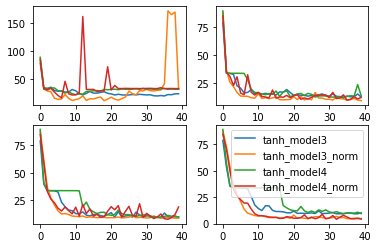

In [ ]:
# 训练误差
plt.subplot(221)
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l1[i])

plt.subplot(222)
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l03[i])

plt.subplot(223)
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l01[i])

plt.subplot(224)
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l005[i], label=name)
plt.legend(loc = 1)

能够看出，随着学习率逐渐变化，拥有BN层的模型表现出更加剧烈的波动，这也说明拥有BN层的模型对学习率变化更加敏感。

&emsp;&emsp;BN层对学习率敏感的背后，其实代表的是BN层可以在更大范围内进行最小值搜索（可以想象成下山的时候山会同步移动），此时调整学习率，也就拥有了更大的优化空间。

### 2.学习率学习曲线

&emsp;&emsp;另外，我们需要知道，学习率作为模型重要参数，学习率的调整也会影响实际模型效果。接下来我们将tanh2模型的学习率调整为0.01，测试模型表现。

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model2 = net_class2(act_fun= torch.tanh, in_features=5)
tanh_model2_norm = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')
     
# 创建模型容器
model_l = [tanh_model2, tanh_model2_norm]           
name_l = ['tanh_model2', 'tanh_model2_norm']

# 核心参数
lr = 0.01
num_epochs = 40

# 模型训练
train_ls, test_ls = model_comparison(model_l = model_l, 
                                     name_l = name_l, 
                                     train_data = train_loader,
                                     test_data = test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = lr, 
                                     cla = False, 
                                     eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

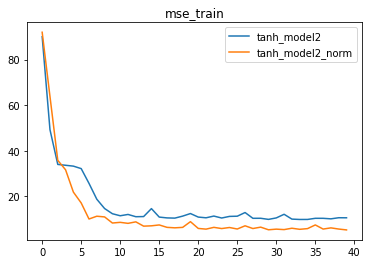

In [ ]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_ls[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

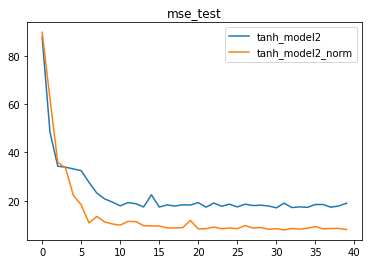

In [ ]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_ls[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

同样，我们统计最后5轮训练误差和测试误差

In [ ]:
# 学习率为0.01时模型误差
train_ls[1:,-5:].mean()
test_ls[1:,-5:].mean()

tensor(6.0480)

tensor(8.5181)

对比此前tanh2模型训练误差和测试误差

In [ ]:
# 学习率为0.03时模型误差
train_lh[1:,-5:].mean()
test_lh[1:,-5:].mean()

tensor(7.6008)

tensor(10.7237)

我们发现，学习率调小之后模型出现这种情况，很大概率是因为学习率较大时，迭代到后期会出现模型迭代解在最小值点附近反复震荡，出于各种原因，无法抵达最小值点。而当我们调小学习率之后，迭代解就能够通过更小的孔。但这也不是绝对的，如果学习率调的过小，不仅会降低迭代速度，同时也极有可能导致迭代解在最小值附近停止不动（每次移动步幅过小）。也就是对于学习率学习曲线来说，实际上也是个U型曲线。我们尝试将学习率调整为0.005和0.001进行建模。

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model2 = net_class2(act_fun= torch.tanh, in_features=5)
tanh_model2_norm = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')
     
# 创建模型容器
model_l = [tanh_model2, tanh_model2_norm]           
name_l = ['tanh_model2', 'tanh_model2_norm']

# 核心参数
lr = 0.001
num_epochs = 40

# 模型训练
train_lss, test_lss = model_comparison(model_l = model_l, 
                                       name_l = name_l, 
                                       train_data = train_loader,
                                       test_data = test_loader,
                                       num_epochs = num_epochs, 
                                       criterion = nn.MSELoss(), 
                                       optimizer = optim.SGD, 
                                       lr = lr, 
                                       cla = False, 
                                       eva = mse_cal)

# 学习率为0.01时模型误差
train_lss[1:,-5:].mean()
test_lss[1:,-5:].mean()

tensor(9.4691)

tensor(16.9594)

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model2 = net_class2(act_fun= torch.tanh, in_features=5)
tanh_model2_norm = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')
     
# 创建模型容器
model_l = [tanh_model2, tanh_model2_norm]           
name_l = ['tanh_model2', 'tanh_model2_norm']

# 核心参数
lr = 0.005
num_epochs = 40

# 模型训练
train_lms, test_lms = model_comparison(model_l = model_l, 
                                       name_l = name_l, 
                                       train_data = train_loader,
                                       test_data = test_loader,
                                       num_epochs = num_epochs, 
                                       criterion = nn.MSELoss(), 
                                       optimizer = optim.SGD, 
                                       lr = lr, 
                                       cla = False, 
                                       eva = mse_cal)

# 学习率为0.05时模型误差
train_lms[1:,-5:].mean()
test_lms[1:,-5:].mean()

tensor(5.0444)

tensor(7.4759)

同样，取最后四个结果取均值，绘制折线图进行观察。

In [ ]:
lr_l = [0.03, 0.01, 0.005, 0.001]
train_ln = [train_lh[1:,-5:].mean(), train_ls[1:,-5:].mean(), train_lms[1:,-5:].mean(), train_lss[1:,-5:].mean()]
test_ln = [test_lh[1:,-5:].mean(), test_ls[1:,-5:].mean(), test_lms[1:,-5:].mean(), test_lss[1:,-5:].mean()]

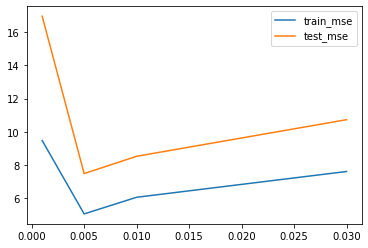

In [ ]:
plt.plot(lr_l, train_ln, label='train_mse')
plt.plot(lr_l, test_ln, label='test_mse')
plt.legend(loc = 1)
#plt.ylim(0, 15)

对于学习率的调整，一般都会出现倒U型曲线。我们能够发现，在当前模型条件下，学习率为0.005左右时模型效果较好。当然，我们这里也只取了四个值进行测试，也有可能最佳学习率在0.006或者0.0051，关于学习率参数的调整策略（LR-scheduler），我们将在下一节进行详细介绍，本节我们将利用此处实验得到的0.005作为学习率进行后续实验。

### 3.不同学习率下不同模型优化效果

&emsp;&emsp;既然学习率学习曲线是U型曲线，那么U型的幅度其实就代表着学习率对于该模型的优化空间，这里我们可以通过简单实验，来观测不同模型的U型曲线的曲线幅度。首先，对于tanh2来说，带BN层的模型学习率优化效果比不带BN层学习率优化效果更好。

In [ ]:
lr_l = [0.03, 0.01, 0.005, 0.001]
train_ln = [train_lh[1:,-5:].mean(), train_ls[1:,-5:].mean(), train_lms[1:,-5:].mean(), train_lss[1:,-5:].mean()]
test_ln = [test_lh[1:,-5:].mean(), test_ls[1:,-5:].mean(), test_lms[1:,-5:].mean(), test_lss[1:,-5:].mean()]
train_l = [train_lh[0:,-5:].mean(), train_ls[0:,-5:].mean(), train_lms[0:,-5:].mean(), train_lss[0:,-5:].mean()]
test_l = [test_lh[0:,-5:].mean(), test_ls[0:,-5:].mean(), test_lms[0:,-5:].mean(), test_lss[0:,-5:].mean()]

<AxesSubplot:>

(4.0, 25.0)

Text(0.5, 1.0, 'With BN(tanh2)')

<AxesSubplot:>

(4.0, 25.0)

Text(0.5, 1.0, 'Without BN(tanh2)')

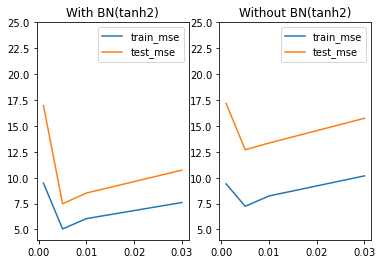

In [ ]:
plt.subplot(121)
plt.plot(lr_l, train_ln, label='train_mse')
plt.plot(lr_l, test_ln, label='test_mse')
plt.legend(loc = 1)
plt.ylim(4, 25)
plt.title('With BN(tanh2)')
plt.subplot(122)
plt.plot(lr_l, train_l, label='train_mse')
plt.plot(lr_l, test_l, label='test_mse')
plt.legend(loc = 1)
plt.ylim(4, 25)
plt.title('Without BN(tanh2)')

In [ ]:
train_lms[1:,-5:].mean()

tensor(5.0444)

类似的，我们可以补充tanh3、4在学习率为0.001时的表现，并进行类似实验。

In [ ]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model3 = net_class3(act_fun= torch.tanh, in_features=5)
tanh_model3_norm = net_class3(act_fun= torch.tanh, in_features=5, BN_model='pre')
tanh_model4 = net_class4(act_fun= torch.tanh, in_features=5)
tanh_model4_norm = net_class4(act_fun= torch.tanh, in_features=5, BN_model='pre')
     
# 创建模型容器
model_l = [tanh_model3, tanh_model3_norm, tanh_model4, tanh_model4_norm]           
name_l = ['tanh_model3', 'tanh_model3_norm', 'tanh_model4', 'tanh_model4_norm']

# 核心参数
lr = 0.001
num_epochs = 40

# 模型训练
train_l001, test_l001 = model_comparison(model_l = model_l, 
                                         name_l = name_l, 
                                         train_data = train_loader,
                                         test_data = test_loader,
                                         num_epochs = num_epochs, 
                                         criterion = nn.MSELoss(), 
                                         optimizer = optim.SGD, 
                                         lr = lr, 
                                         cla = False, 
                                         eva = mse_cal)

In [ ]:
train_l001

tensor([[78.6160, 73.0764, 62.7336, 49.7248, 39.8199, 35.4495, 34.1540, 33.8683,
         33.8073, 33.7815, 33.7592, 33.7343, 33.7035, 33.6606, 33.5913, 33.4548,
         33.0735, 31.2249, 26.4116, 22.3701, 16.3730, 14.1721, 13.5942, 12.5150,
         11.3104, 10.8606, 10.5622, 11.5685, 10.1088,  9.9441, 10.6014, 10.3630,
          9.8647, 10.0165,  9.6261,  9.9919,  9.6189,  9.9426,  9.6061,  9.7663],
        [87.5913, 83.8961, 78.8945, 71.5308, 62.9129, 53.6322, 43.6664, 36.2891,
         31.4903, 27.8138, 25.3230, 22.6066, 19.1205, 16.6132, 15.5674, 13.9563,
         13.0120, 12.7016, 11.8167, 11.5438, 11.1577, 10.9892, 10.6801, 10.6650,
         10.3403, 10.0786, 10.3988,  9.7349,  9.6953,  9.4739,  9.4324,  9.4121,
          9.3468,  9.1834,  9.1460,  9.0151,  9.0186,  8.8875,  8.9087,  9.0112],
        [88.9965, 81.7952, 68.5453, 52.4968, 40.7098, 35.6605, 34.2223, 33.9285,
         33.8783, 33.8672, 33.8606, 33.8549, 33.8497, 33.8450, 33.8408, 33.8370,
         33.8336, 33.8305,

In [ ]:
lr_l = [0.03, 0.01, 0.005, 0.001]
train_ln = [train_l03[1:,-5:].mean(), train_l01[1:,-5:].mean(), train_l005[1:,-5:].mean(), train_l001[1:,-5:].mean()]
test_ln = [test_l03[1:,-5:].mean(), test_l01[1:,-5:].mean(), test_l005[1:,-5:].mean(), test_l001[1:,-5:].mean()]
train_l = [train_l03[0:,-5:].mean(), train_l01[0:,-5:].mean(), train_l005[0:,-5:].mean(), train_l001[0:,-5:].mean()]
test_l = [test_l03[0:,-5:].mean(), test_l01[0:,-5:].mean(), test_l005[0:,-5:].mean(), test_l1[0:,-5:].mean()]

<AxesSubplot:>

(4.0, 25.0)

Text(0.5, 1.0, 'With BN(tanh3)')

<AxesSubplot:>

(4.0, 25.0)

Text(0.5, 1.0, 'Without BN(tanh3)')

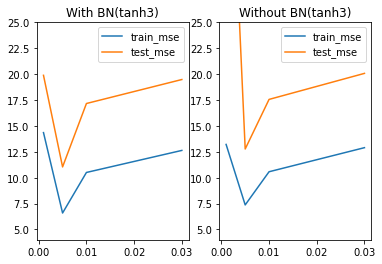

In [ ]:
plt.subplot(121)
plt.plot(lr_l, train_ln, label='train_mse')
plt.plot(lr_l, test_ln, label='test_mse')
plt.legend(loc = 1)
plt.ylim(4, 25)
plt.title('With BN(tanh3)')
plt.subplot(122)
plt.plot(lr_l, train_l, label='train_mse')
plt.plot(lr_l, test_l, label='test_mse')
plt.legend(loc = 1)
plt.ylim(4, 25)
plt.title('Without BN(tanh3)')

In [ ]:
lr_l = [0.03, 0.01, 0.005, 0.001]
train_ln = [train_l03[3:,-5:].mean(), train_l01[3:,-5:].mean(), train_l005[3:,-5:].mean(), train_l001[3:,-5:].mean()]
test_ln = [test_l03[3:,-5:].mean(), test_l01[3:,-5:].mean(), test_l005[3:,-5:].mean(), test_l001[3:,-5:].mean()]
train_l = [train_l03[2:,-5:].mean(), train_l01[2:,-5:].mean(), train_l005[2:,-5:].mean(), train_l001[2:,-5:].mean()]
test_l = [test_l03[2:,-5:].mean(), test_l01[2:,-5:].mean(), test_l005[2:,-5:].mean(), test_l1[2:,-5:].mean()]

<AxesSubplot:>

(4.0, 25.0)

Text(0.5, 1.0, 'With BN(tanh4)')

<AxesSubplot:>

(4.0, 25.0)

Text(0.5, 1.0, 'Without BN(tanh4)')

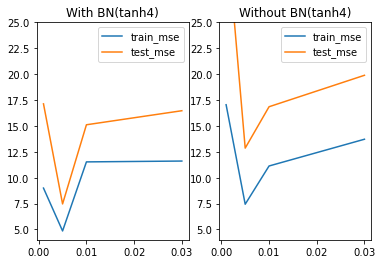

In [ ]:
plt.subplot(121)
plt.plot(lr_l, train_ln, label='train_mse')
plt.plot(lr_l, test_ln, label='test_mse')
plt.legend(loc = 1)
plt.ylim(4, 25)
plt.title('With BN(tanh4)')
plt.subplot(122)
plt.plot(lr_l, train_l, label='train_mse')
plt.plot(lr_l, test_l, label='test_mse')
plt.legend(loc = 1)
plt.ylim(4, 25)
plt.title('Without BN(tanh4)')

整体来看，带BN层的模型对学习率调整更加敏感，优化空间更大。

In [ ]:
train_lms[0:,-5:].mean()
train_l005[0:,-5:].mean()
train_l005[2:,-5:].mean()

tensor(7.2374)

tensor(7.3688)

tensor(7.4356)

In [ ]:
train_lms[1:,-5:].mean()
train_l005[1:,-5:].mean()
train_l005[3:,-5:].mean()

tensor(5.0444)

tensor(6.5871)

tensor(4.8542)

&emsp;&emsp;BN层这种伴随模型更加复杂、对学习率也更加敏感的属性，最终会使得更加复杂的模型在相同的学习率下表现更好。这是一个隐藏很深的结论，但同时也是一个非常有用的结论。

&emsp;&emsp;当然，截至目前，带BN的tanh4在当前数据集上表现最好，并且远超不带BN的其他所有神经网络。据此我们可以得出结论，学习率调整在复杂且带BN层模型上表现效果更好。但值得一提的是，对于加入BN层的tanh模型的调参，目前还只是冰山一角，以目前所掌握的调参手段，尚未发挥BN层的全部效能，因此效果仍然只能说是中规中矩。

&emsp;&emsp;另外，本节重点强调了关于学习率调整的模型优化方法，也花费了较大篇幅去探索学习率学习曲线的U型特性，该内容也将为后续课程的学习率优化部分做铺垫。

## 四、带BN层的神经网络模型综合调整策略总结

&emsp;&emsp;最后，我们总结下截至目前，针对BN层的神经网络模型调参策略。

- 简单数据、简单模型下不用BN层，加入BN层效果并不显著；

- BN层的使用需要保持running_mean和running_var的无偏性，因此需要谨慎调整batch_size；

- 学习率是重要的模型优化的超参数，一般来说学习率学习曲线都是U型曲线；

- 从学习率调整角度出发，对于加入BN层的模型，学习率调整更加有效；对于带BN层模型角度来说，BN层能够帮助模型拓展优化空间，使得很多优化方法都能在原先无效的模型上生效；

- 对于复杂问题，在计算能力能够承担的范围内，应当首先构建带BN层的复杂模型，然后再试图进行优化，就像上文所述，很多优化方法只对带BN层的模型有效；

其他拓展方面结论：

- 关于BN和Xavier/Kaiming方法，一般来说，使用BN层的模型不再会用参数初始化方法，从理论上来看添加BN层能够起到参数初始化的相等效果；（另外，带BN层模型一般也不需要使用Dropout方法）

- 本节尚未讨论ReLU激活函数的优化，相关优化方法将放在后续进行详细讨论，但需要知道的是，对于ReLU叠加的模型来说，加入BN层之后能够有效缓解Dead ReLU Problem，此时无须刻意调小学习率，能够在收敛速度和运算结果间保持较好的平衡。

- BN层是目前大部分深度学习模型的标配，但前提是你有能力去对其进行优化；